## Problem Tanımı


- 1) Daireler üretme fonksiyonu yerine yeni bir görüntü üretme fonksiyonu yazılacak.

- 2) Bu fonksiyona girdi olarak NesneSayısı değişkeni gönderilecek.

- 3) Örneğin NesneSayısı=15 olduğunda görüntüye daire, kare, dikdörtgen, üçgen, elips nesnelerinin her birinden 15 adet eklenecek. Her bir nesnenin görüntüdeki konumu random belirlenecek. Görüntü sınırlarının dışına çıkılmayacak. Ayrıca nesne büyüklükleride makul aralıklarda random olacak. Nesne rengi 0-255 aralığında random belirlenecek. Önce bir daire, sonra bir kare, sonra bir dikdörtgen şeklinde nesneler sırayla görüntüye eklenecek. Yani 15 daire, 15 kare şeklinde eklenmeyecek.

- 4) LabelNesnesi değişkeni kullanıcı tarafından girilecek. Örneğin LabelNesnesi = 'daire' girildiğinde label görüntülerinde sadece daire olan bölge beyaz, diğer tüm bölgeler siyah olacak.

- 5) Yapay zeka modelinin 20 epoch eğitimi yapılacak ve model.pth kaydedilecek.

- 6) Yan yana "test görüntüsü, test labeli ve test tahmini" çizilmek şartıyla, 10 adet test sonuuc alt alta gösterilecek.

## Veri hakkında

* Giriş görüntüsü: [120, 120] boyutlarında ve 5 farklı renkte daire içerecek
* Çıkış görüntüsü: [120, 120] boyutlarında ve 0-1 değerlerini içerecek

## Çözüm Aşamaları

### Kütüphaneleri import et

In [ ]:
!pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 12.6 MB/s eta 0:00:00


In [ ]:
import logging
import os
import sys
import tempfile
from glob import glob
import numpy as np

import torch
from PIL import Image
from torch.utils.tensorboard import SummaryWriter

import monai
from monai.data import ArrayDataset, create_test_image_2d, decollate_batch, DataLoader
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImage,
    RandRotate90,
    RandSpatialCrop,
    RandSpatialCropSamples,
    ScaleIntensity)
from monai.visualize import plot_2d_or_3d_image
import matplotlib.pyplot as plt

### Sentetik görüntü ve maske üret

In [ ]:
import random
import math
from PIL import Image, ImageDraw, ImageChops

def generate_synthetic_image(NesneSayisi, LabelNesnesi, image_size=128):
    """
    Synthetic 128x128 görüntü ve etiket görüntüsü üretir.

    Parametreler:
      - NesneSayisi: Her bir şekilden kaç adet üretileceği (toplam nesne sayısı = 5 * NesneSayisi)
      - LabelNesnesi: Label görüntüsünde beyaz (255) yapılacak nesne tipi.
                      (Örneğin, "daire", "kare", "dikdörtgen", "üçgen", "elips")
      - image_size: Görüntü boyutu (default 128)

    Dönüş:
      - img: Oluşturulan PIL görüntüsü (mode "L")
      - label_img: İlgili label görüntüsü (mode "L")
    """
    # Arka planı siyah olan boş görüntüler oluşturuluyor.
    img = Image.new("L", (image_size, image_size), 0)
    label_img = Image.new("L", (image_size, image_size), 0)

    draw_img = ImageDraw.Draw(img)
    draw_lbl = ImageDraw.Draw(label_img)

    # Nesnelerin yerleştiği alanı takip etmek için binary (1-bit) işgal maskesi oluşturuluyor.
    occupancy = Image.new("1", (image_size, image_size), 0)

    # Şekiller istenen sırayla:
    shapes = ["daire", "kare", "dikdörtgen", "üçgen", "elips"]

    max_attempts = 100  # Her nesne için maksimum deneme sayısı

    # Her bir şekilden NesneSayisi adet üretilecek;
    # nesneler round-robin (daire, kare, dikdörtgen, üçgen, elips, daire, ...) şeklinde çizilir.
    for i in range(NesneSayisi):
        for shape in shapes:
            placed = False
            attempts = 0
            while not placed and attempts < max_attempts:
                attempts += 1
                # Rastgele renk (0-255 arası); image için kullanılır.
                color = random.randint(0, 255)
                # Label görüntüsü için; eğer bu şekil LabelNesnesi ile eşleşiyorsa beyaz, aksi halde siyah.
                fill_val = 255 if shape == LabelNesnesi else 0

                # Geçici maske oluşturuluyor, bu maske üzerinde nesne çizilip çakışma kontrolü yapılacak.
                candidate_mask = Image.new("1", (image_size, image_size), 0)
                candidate_draw = ImageDraw.Draw(candidate_mask)

                if shape == "daire":
                    # Rastgele yarıçap seçimi (20-50); 128x128 için uygun alan içerisinde kalması için kontrol ediliyor.
                    r = random.randint(10, min(25, image_size//2))
                    cx = random.randint(r, image_size - r)
                    cy = random.randint(r, image_size - r)
                    bbox = [cx - r, cy - r, cx + r, cy + r]
                    candidate_draw.ellipse(bbox, fill=1)

                    # Çakışma kontrolü
                    overlap = ImageChops.logical_and(occupancy, candidate_mask)
                    if overlap.getbbox() is None:
                        draw_img.ellipse(bbox, fill=color)
                        draw_lbl.ellipse(bbox, fill=fill_val)
                        occupancy = ImageChops.logical_or(occupancy, candidate_mask)
                        placed = True

                elif shape == "kare":
                    side = random.randint(10, min(25, image_size//2))
                    x = random.randint(0, image_size - side)
                    y = random.randint(0, image_size - side)
                    bbox = [x, y, x + side, y + side]
                    candidate_draw.rectangle(bbox, fill=1)

                    overlap = ImageChops.logical_and(occupancy, candidate_mask)
                    if overlap.getbbox() is None:
                        draw_img.rectangle(bbox, fill=color)
                        draw_lbl.rectangle(bbox, fill=fill_val)
                        occupancy = ImageChops.logical_or(occupancy, candidate_mask)
                        placed = True

                elif shape == "dikdörtgen":
                    width = random.randint(10, min(30, image_size//2))
                    height = random.randint(10, min(30, image_size//2))
                    x = random.randint(0, image_size - width)
                    y = random.randint(0, image_size - height)
                    bbox = [x, y, x + width, y + height]
                    candidate_draw.rectangle(bbox, fill=1)

                    overlap = ImageChops.logical_and(occupancy, candidate_mask)
                    if overlap.getbbox() is None:
                        draw_img.rectangle(bbox, fill=color)
                        draw_lbl.rectangle(bbox, fill=fill_val)
                        occupancy = ImageChops.logical_or(occupancy, candidate_mask)
                        placed = True

                elif shape == "üçgen":
                    side = random.randint(10, min(25, image_size//2))
                    h = int(side * (math.sqrt(3) / 2))
                    x = random.randint(0, image_size - side)
                    y = random.randint(0, image_size - h)
                    # Üçgenin köşe noktaları (sol alt, sağ alt, üst orta)
                    vertices = [(x, y + h), (x + side, y + h), (x + side/2, y)]
                    vertices_int = [(int(px), int(py)) for px, py in vertices]
                    candidate_draw.polygon(vertices_int, fill=1)

                    overlap = ImageChops.logical_and(occupancy, candidate_mask)
                    if overlap.getbbox() is None:
                        draw_img.polygon(vertices_int, fill=color)
                        draw_lbl.polygon(vertices_int, fill=fill_val)
                        occupancy = ImageChops.logical_or(occupancy, candidate_mask)
                        placed = True

                elif shape == "elips":
                    rx = random.randint(10, min(25, image_size//2))
                    ry = random.randint(10, min(25, image_size//2))
                    cx = random.randint(rx, image_size - rx)
                    cy = random.randint(ry, image_size - ry)
                    bbox = [cx - rx, cy - ry, cx + rx, cy + ry]
                    candidate_draw.ellipse(bbox, fill=1)

                    overlap = ImageChops.logical_and(occupancy, candidate_mask)
                    if overlap.getbbox() is None:
                        draw_img.ellipse(bbox, fill=color)
                        draw_lbl.ellipse(bbox, fill=fill_val)
                        occupancy = ImageChops.logical_or(occupancy, candidate_mask)
                        placed = True

            # Eğer max_attempts'a ulaşılırsa, bu nesne yerleştirilemeden geçiliyor.
    return img, label_img

# Örnek kullanım:
if __name__ == "__main__":
    # Her şekilden 5 adet üret, label olarak sadece "daire"yi işaretle.
    synthetic_img, label_image = generate_synthetic_image(5, "daire", image_size=128)
    synthetic_img.show(title="Synthetic Image")
    label_image.show(title="Label Image")


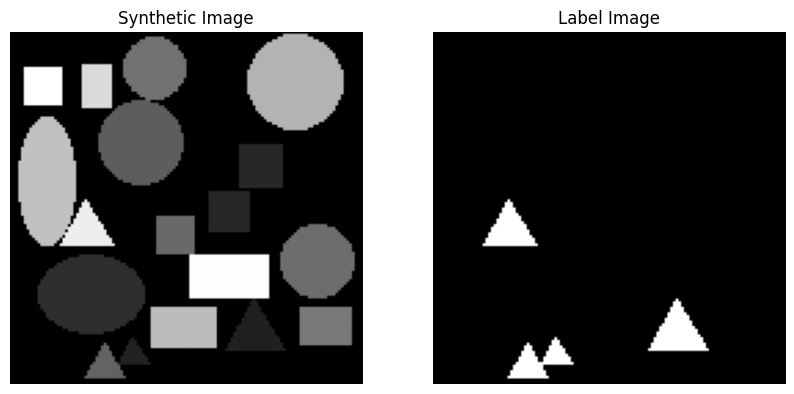

In [ ]:
synthetic_img, label_image = generate_synthetic_image(4, "üçgen")

f, axarr = plt.subplots(1,2,figsize=(10,5))
axarr[0].imshow(synthetic_img, cmap='gray')
axarr[0].set_title('Synthetic Image')
axarr[0].axis('off')
axarr[1].imshow(label_image, cmap='gray')
axarr[1].set_title('Label Image')
axarr[1].axis('off')
plt.show()

In [ ]:
tempdir = "tmp/"
os.makedirs(tempdir, exist_ok=True)
print(f"generating synthetic data to {tempdir} (this may take a while)")

shapes = ["daire", "kare", "dikdörtgen", "üçgen", "elips"]

for i in range(100):
    im, label = generate_synthetic_image(4, shapes[3])
    im.save(os.path.join(tempdir, f"img{i:d}.png"))
    label.save(os.path.join(tempdir, f"label{i:d}.png"))

generating synthetic data to tmp/ (this may take a while)


### Klasördeki görüntü ve maskeleri tek değişkene bağla

In [ ]:
images = sorted(glob(os.path.join(tempdir, "img*.png")))
labels = sorted(glob(os.path.join(tempdir, "label*.png")))

### [Compose](https://docs.monai.io/en/stable/transforms.html): Görüntü üzerinde yapılacak dönüşümleri birleştir

In [ ]:
WinSize = 128
train_imtrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCrop((WinSize, WinSize), random_size=False), # önemli
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)
train_labeltrans = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        ScaleIntensity(),
        RandSpatialCrop((WinSize, WinSize), random_size=False), # önemli
        RandRotate90(prob=0.5, spatial_axes=(0, 1)),
    ]
)

test_imtrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])
test_labeltrans = Compose([LoadImage(image_only=True, ensure_channel_first=True), ScaleIntensity()])

post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

###  [Arraydataset](https://docs.monai.io/en/stable/data.html#arraydataset): Klasördeki görüntülerin okunması ve dönüştürülmesi nesnesi:

In [ ]:
ds = ArrayDataset(images, train_imtrans, labels, train_labeltrans)

### [DataLoader](https://https://docs.monai.io/en/stable/modules.html#datasets-and-data-loading): Yüklenen veri nesnesi


In [ ]:
loader = DataLoader(ds, batch_size=10, num_workers=2, pin_memory=torch.cuda.is_available())

### Tüm Batch Boyutlarını İnceleme


In [ ]:
for i, (im, label) in enumerate(loader):
    print(f"Batch {i + 1} - Görüntü Boyutu: {im.shape}, Etiket Boyutu: {label.shape}")

Batch 1 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 2 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 3 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 4 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 5 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 6 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 7 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 8 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 9 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Size([10, 1, 128, 128])
Batch 10 - Görüntü Boyutu: torch.Size([10, 1, 128, 128]), Etiket Boyutu: torch.Siz

### Tüm Verinin Toplam Boyutunu Hesaplama

In [ ]:
total_images = 0
total_labels = 0

for batch_data in loader:
    im, label = batch_data[0], batch_data[1]
    total_images += im.shape[0]  # Batch içindeki görüntü sayısını ekle
    total_labels += label.shape[0]  # Batch içindeki etiket sayısını ekle

print(f"Toplam Görüntü Sayisi: {total_images}")
print(f"Toplam Etiket Sayisi: {total_labels}")

Toplam Görüntü Sayisi: 100
Toplam Etiket Sayisi: 100


### İlk görseller

In [ ]:
import matplotlib.pyplot as plt

def goster(goruntuler):
    n = len(goruntuler)  # Görüntü sayısını belirle
    fig, axs = plt.subplots(1, n, figsize=(5*n, 5))

    if n == 1:
        axs = [axs]  # Tek görüntü durumunda listeye çevir

    for i, goruntu in enumerate(goruntuler):
        axs[i].imshow(goruntu, cmap='gray')
        axs[i].axis('off')  # Eksenleri gizle

        # Eğer goruntu bir NumPy array veya PyTorch tensor ise shape kullan
        if hasattr(goruntu, 'shape'):
            height, width = goruntu.shape[:2]
        else:
            width, height = goruntu.size  # PIL Image için

        # Görüntü üzerine boyut bilgisini ekle
        axs[i].text(
            10, 20, f'{width}x{height}', color='white', fontsize=12,
            bbox=dict(facecolor='black', alpha=0.7, edgecolor='none')
        )

    plt.tight_layout()
    plt.show()


torch.Size([10, 1, 128, 128]) torch.Size([10, 1, 128, 128])


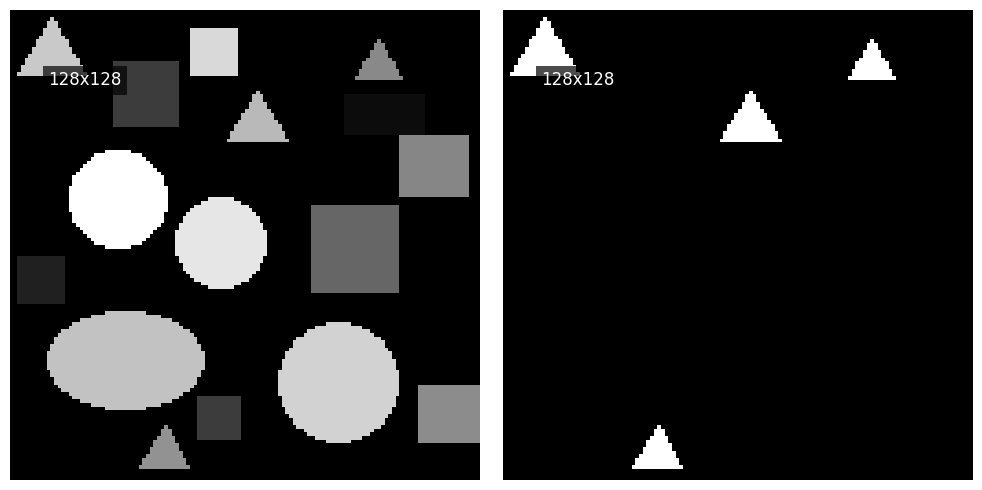

In [ ]:
im, label = monai.utils.misc.first(loader)
print(im.shape, label.shape)
goster([im[0, 0],label[0, 0]])

### Veri Kümesinin Asıl Boyutunu Görüntüleme

In [ ]:
print(f"Dataset Boyutu (Toplam Örnek Sayisi): {len(loader.dataset)}")

Dataset Boyutu (Toplam Örnek Sayisi): 100


### Detaylı Boyut Analizi (Loader İçindeki Tüm Veriler)

In [ ]:
# İlk batch'in boyutlarını alın
first_batch_im, first_batch_label = next(iter(loader))

# Boyutlara göre işlemleri yönetin
if len(first_batch_im.shape) == 5:
    B, C, D, H, W = first_batch_im.shape
    print(f"Veri 5D: Batch Boyutu = {B}, Kanal Sayisi = {C}, Derinlik = {D}, Yükseklik = {H}, Genişlik = {W}")
elif len(first_batch_im.shape) == 4:
    B, C, H, W = first_batch_im.shape
    print(f"Veri 4D: Batch Boyutu = {B}, Kanal Sayisi = {C}, Yükseklik = {H}, Genişlik = {W}")
else:
    print(f"Beklenmedik veri boyutu: {first_batch_im.shape}")

Veri 4D: Batch Boyutu = 10, Kanal Sayisi = 1, Yükseklik = 128, Genişlik = 128


### Veri Hafıza Kullanımını Hesaplama

In [ ]:
import numpy as np

total_memory = 0

for im, _ in loader:
    total_memory += np.prod(im.shape) * im.element_size()

print(f"Toplam Veri Belleği: {total_memory / 1e6:.2f} MB")


Toplam Veri Belleği: 6.55 MB


### Eğitim için ilk 20, test için son 20

In [ ]:
train_ds = ArrayDataset(images[:50], train_imtrans, labels[:50], train_labeltrans)
train_loader = DataLoader(train_ds, batch_size=4, shuffle=True, num_workers=8, pin_memory=torch.cuda.is_available())

test_ds = ArrayDataset(images[-50:], test_imtrans, labels[-50:], test_labeltrans)
test_loader = DataLoader(test_ds, batch_size=1, num_workers=4, pin_memory=torch.cuda.is_available())

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


### Benzerlik ölçümü için metrik tanımı

In [ ]:
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

### Modeli oluştur: UNet, DiceLoss and Adam optimizer

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = monai.networks.nets.UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    strides=(2, 2),
    num_res_units=2,
).to(device)
loss_function = monai.losses.DiceLoss(sigmoid=True)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

### Eğitime başla

In [ ]:
epoch_loss_values = list()
writer = SummaryWriter()
for epoch in range(50): # bütün veriyi 2 defa gör
    print("-" * 20)
    print(f"epoch {epoch + 1}/{20}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader: # batch=4 oldugu icin, iterasyon
        step += 1
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device) # GPU ya taşı
        optimizer.zero_grad()
        outputs = model(inputs)  # YZ modeline ver
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_len = len(train_ds) // train_loader.batch_size
        print(f"{step}/{epoch_len}, train_loss: {loss.item():.4f}")
        writer.add_scalar("train_loss", loss.item(), epoch_len * epoch + step)
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

--------------------
epoch 1/20
1/12, train_loss: 0.8218
2/12, train_loss: 0.8491
3/12, train_loss: 0.8235
4/12, train_loss: 0.8220
5/12, train_loss: 0.8123
6/12, train_loss: 0.8400
7/12, train_loss: 0.8106
8/12, train_loss: 0.7995
9/12, train_loss: 0.8095
10/12, train_loss: 0.8221
11/12, train_loss: 0.8505
12/12, train_loss: 0.8271
13/12, train_loss: 0.8785
epoch 1 average loss: 0.8282
--------------------
epoch 2/20
1/12, train_loss: 0.8380
2/12, train_loss: 0.8374
3/12, train_loss: 0.8029
4/12, train_loss: 0.8383
5/12, train_loss: 0.7847
6/12, train_loss: 0.7930
7/12, train_loss: 0.8441
8/12, train_loss: 0.8586
9/12, train_loss: 0.8073
10/12, train_loss: 0.8343
11/12, train_loss: 0.8347
12/12, train_loss: 0.8511
13/12, train_loss: 0.7718
epoch 2 average loss: 0.8228
--------------------
epoch 3/20
1/12, train_loss: 0.7949
2/12, train_loss: 0.8420
3/12, train_loss: 0.8149
4/12, train_loss: 0.8019
5/12, train_loss: 0.8333
6/12, train_loss: 0.8342
7/12, train_loss: 0.8240
8/12, train_l

### Modeli kaydet

In [ ]:
torch.save(model.state_dict(), "tmp/model.pth")

### Test çıktısını al

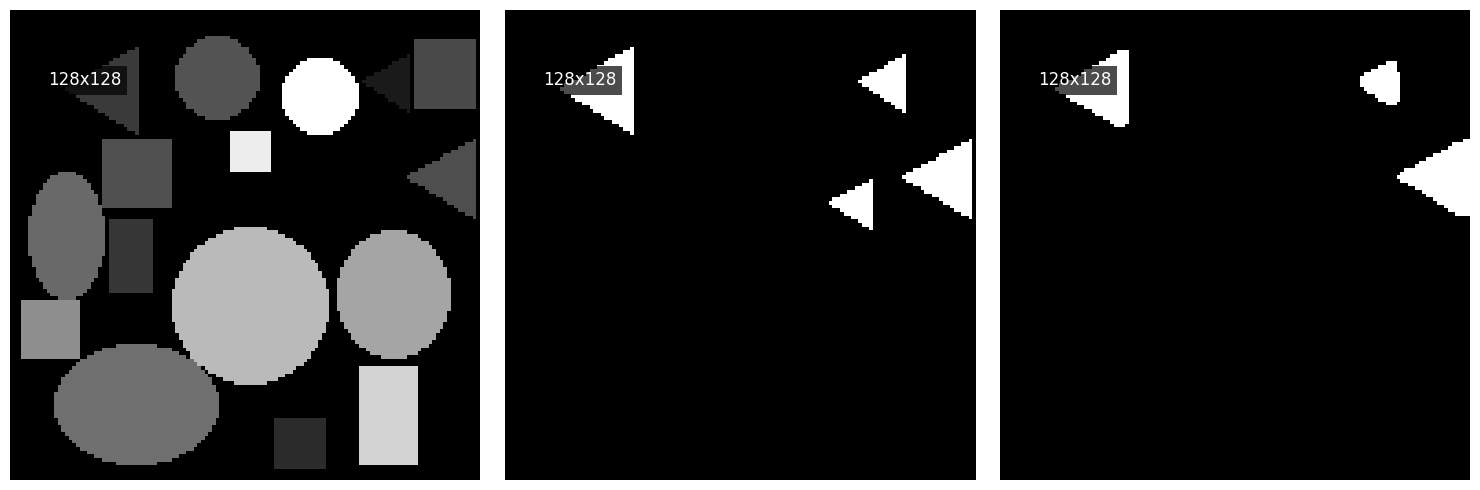

test_images boyutlari: torch.Size([1, 1, 128, 128])
test_outputs1 boyutlari: torch.Size([1, 1, 128, 128])


In [ ]:
img = 0
roi_size = (WinSize, WinSize)
sw_batch_size = 4

for test_data in test_loader:
    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    test_outputs1 = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
    test_outputs2 = [post_trans(i) for i in decollate_batch(test_outputs1)]
    goster([test_images[0][0].cpu().detach().numpy(), test_labels[0][0].cpu().detach().numpy(),test_outputs2[0][0].cpu().detach().numpy()])

    print(f"test_images boyutlari: {test_images.shape}")
    print(f"test_outputs1 boyutlari: {test_outputs1.shape}")
    break

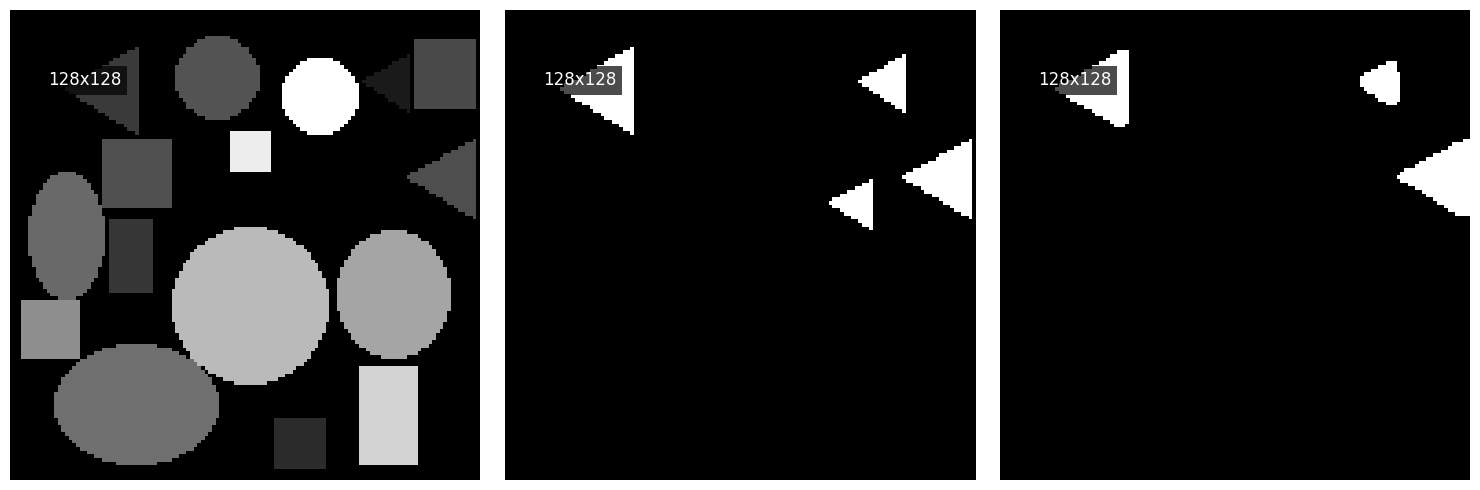

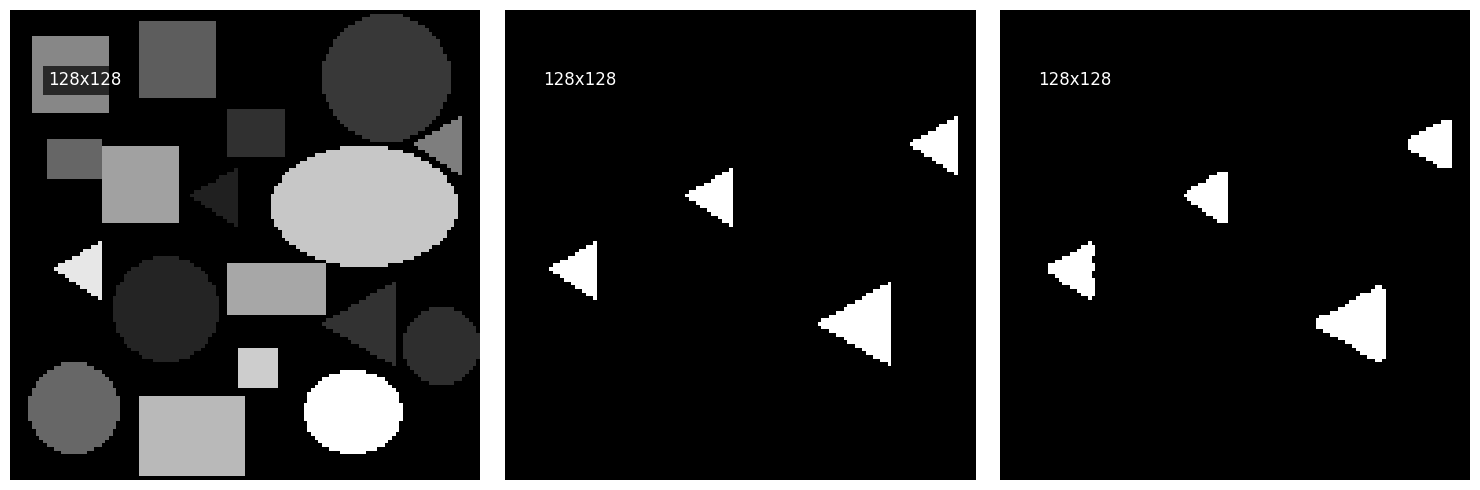

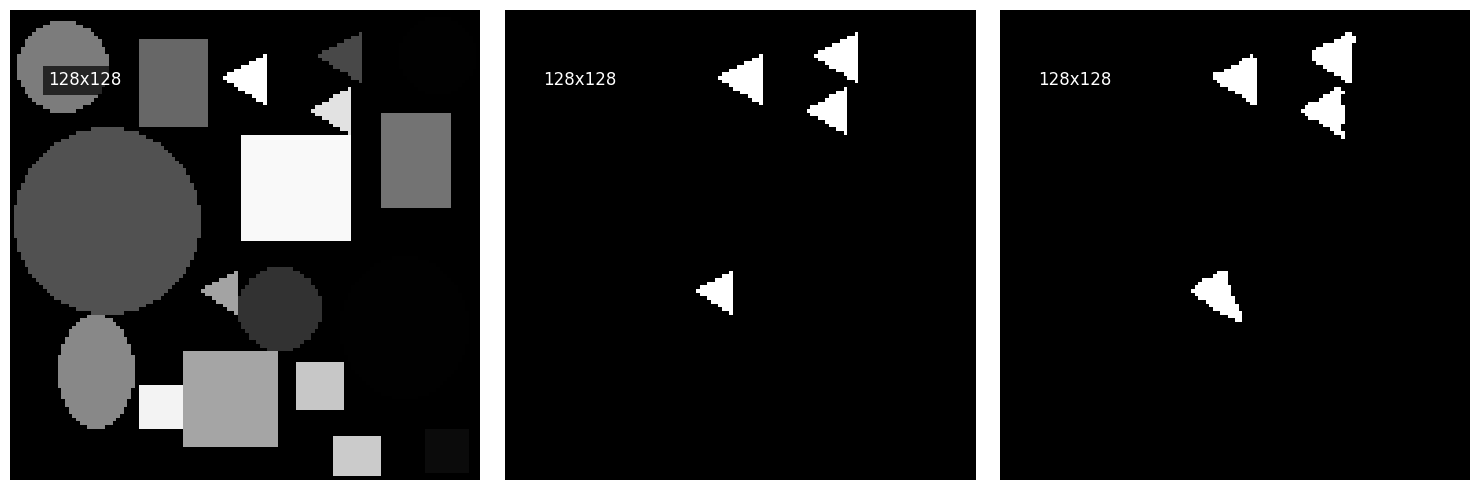

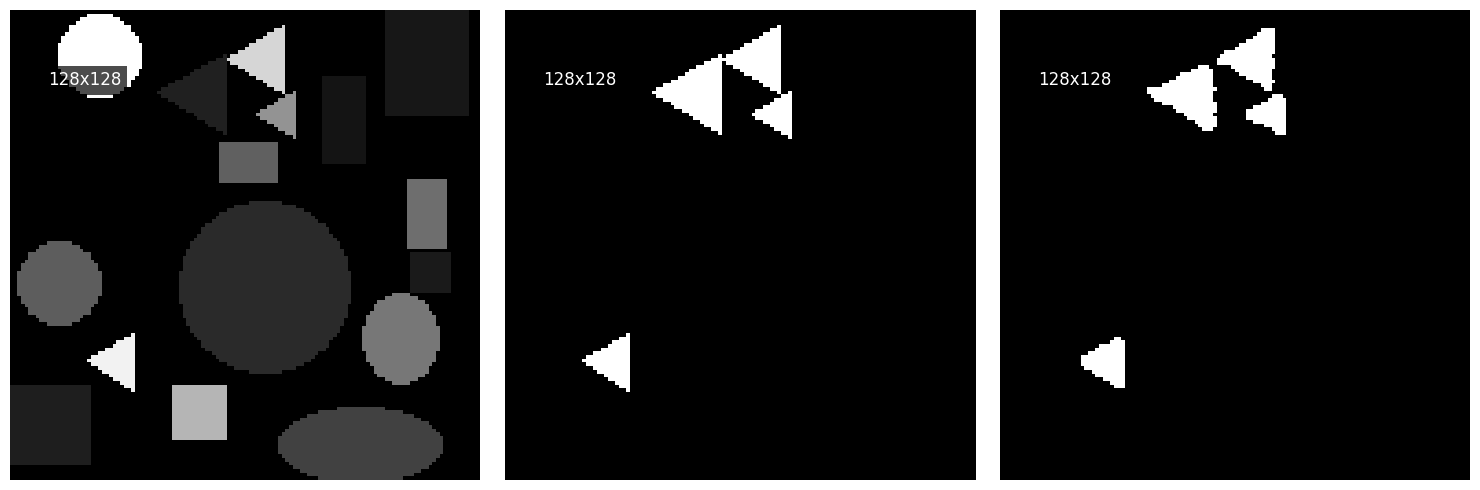

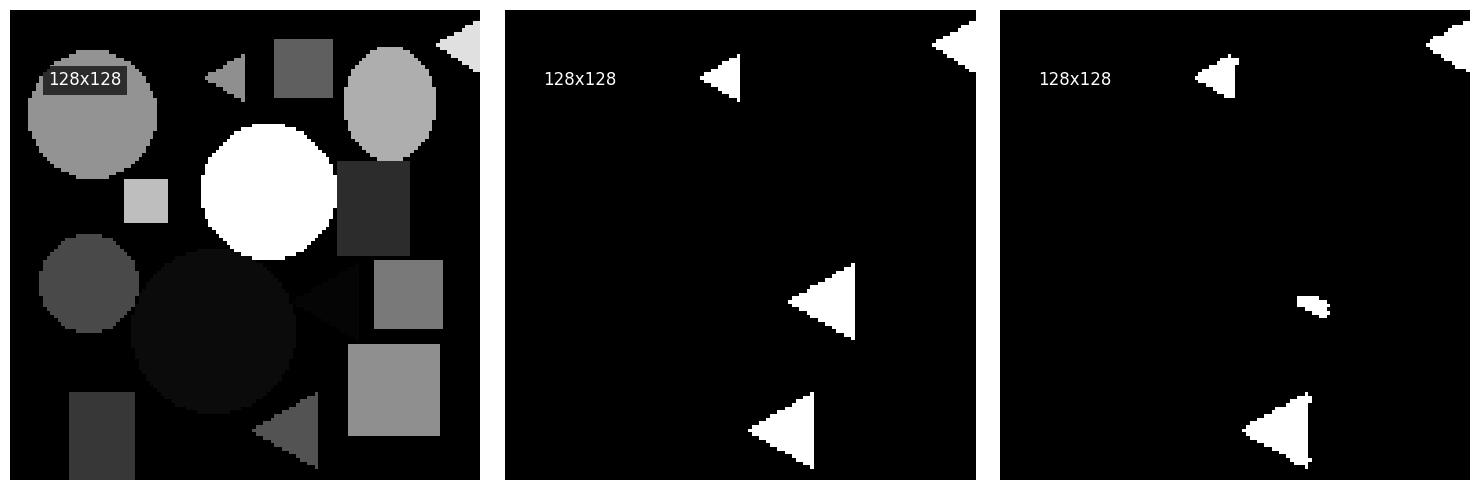

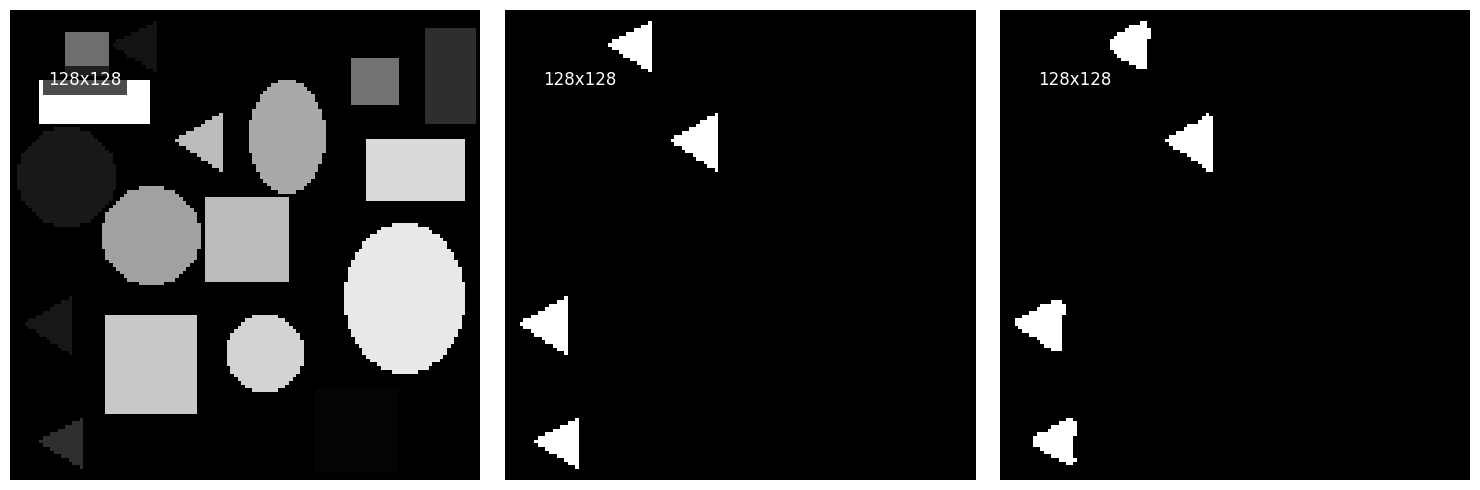

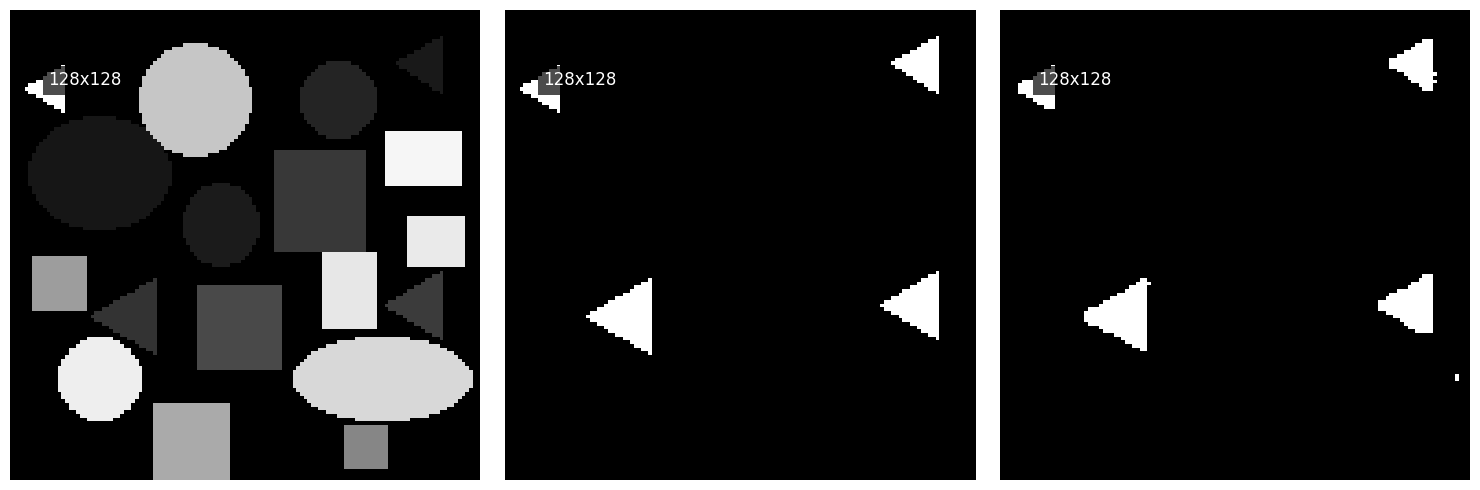

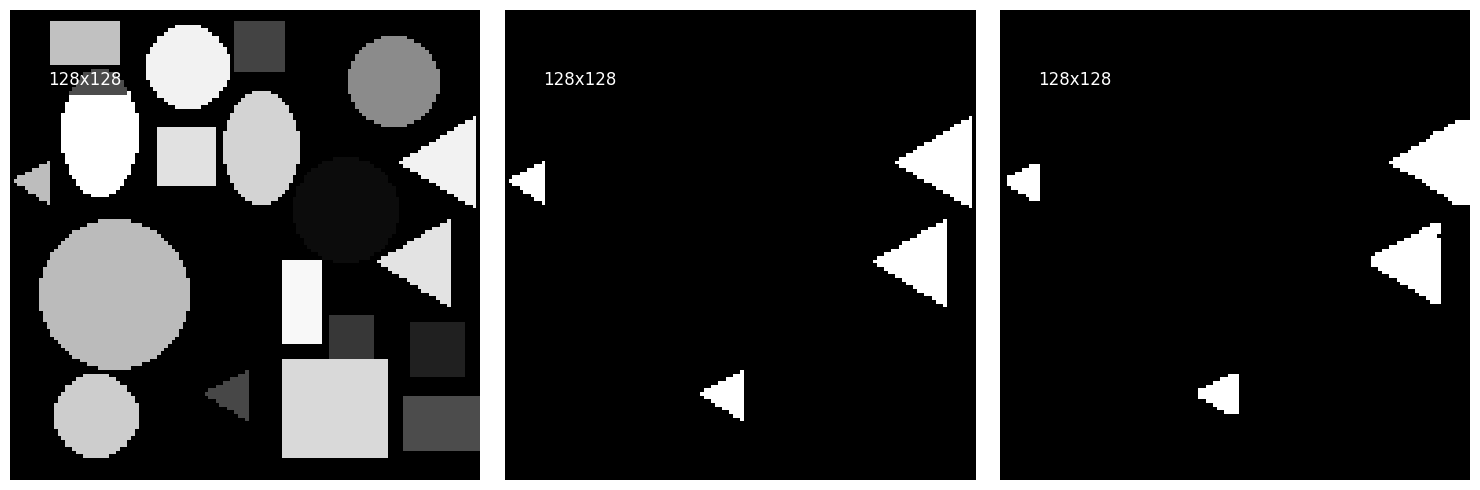

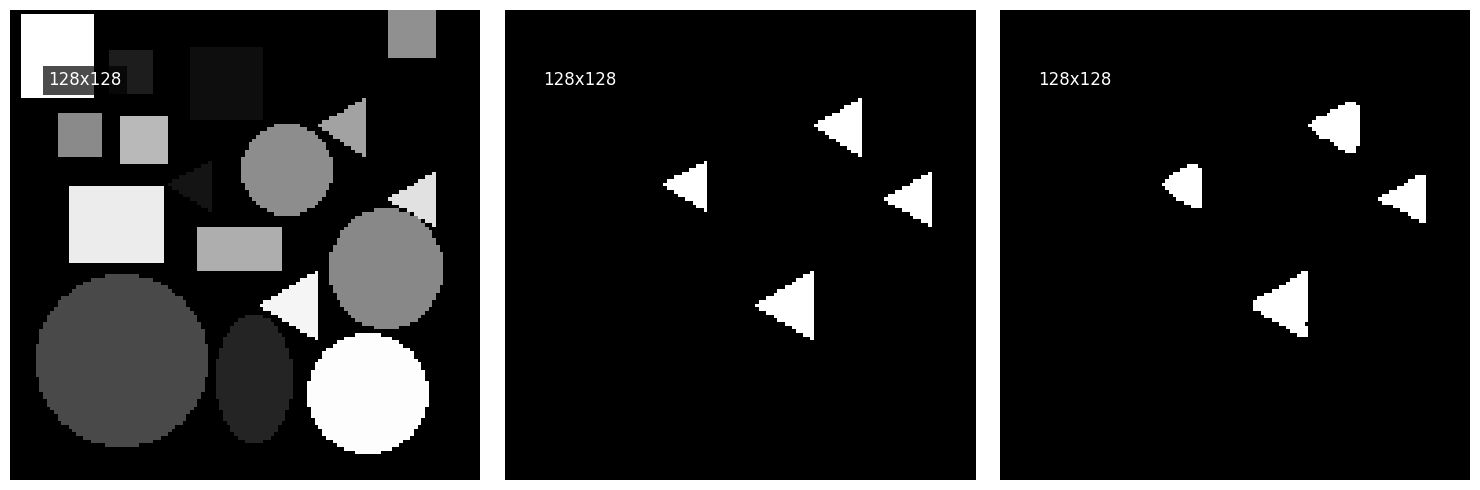

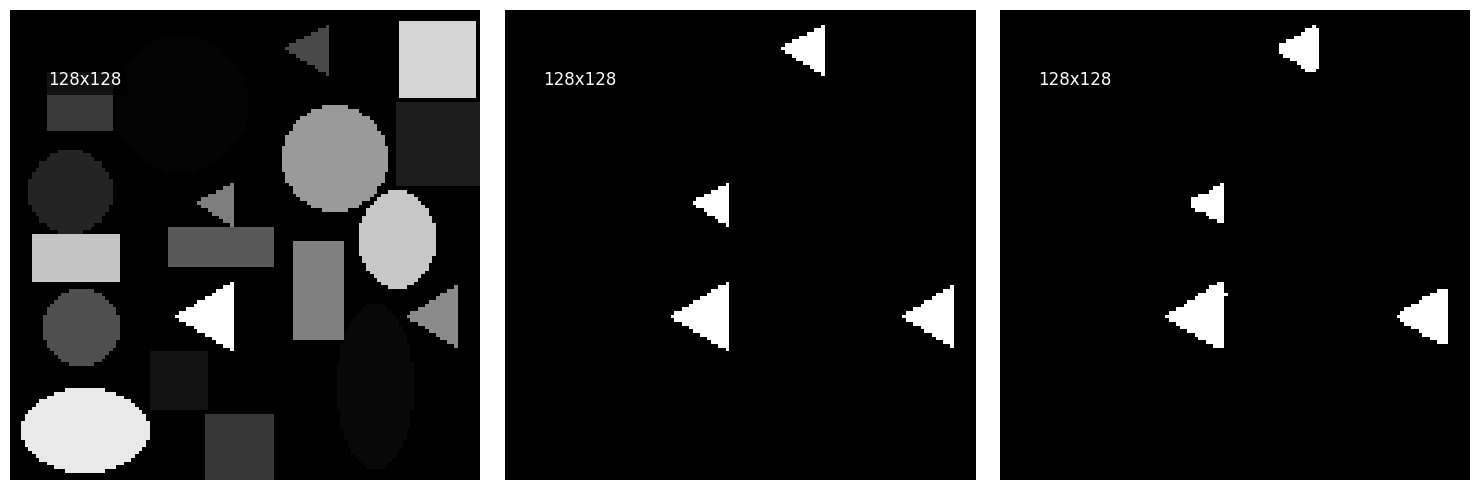

In [ ]:
num_test_images = 10  # 10 test görüntüsü gösterilecek
image_index = 0

for test_data in test_loader:
    if image_index >= num_test_images:
        break

    test_images, test_labels = test_data[0].to(device), test_data[1].to(device)
    test_outputs1 = sliding_window_inference(test_images, roi_size, sw_batch_size, model)
    test_outputs2 = [post_trans(i) for i in decollate_batch(test_outputs1)]
    goster([test_images[0][0].cpu().detach().numpy(), test_labels[0][0].cpu().detach().numpy(),test_outputs2[0][0].cpu().detach().numpy()])

    image_index += 1
